# GPR to predict the number of atoms


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from sklearn.model_selection import train_test_split
from scipy.signal import savgol_filter
from sklearn.metrics import r2_score
import sklearn.gaussian_process as gp

In [13]:
df = pd.read_csv('mu_cn10000.csv')


In [14]:
def GPR_get_CN(features, labels, percent_test):
    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=percent_test, random_state = 42)
    # Import the model we are using
    kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))
    model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)
    gpr = model.fit(train_features, train_labels)
    params = model.kernel_.get_params()
    pred_labels, std = model.predict(test_features, return_std=True)
    MSE = ((pred_labels-test_labels)**2).mean()
    RMSE = MSE**(1/2)
    print('MSE = ', MSE)
    print('RMSE =', RMSE)
    rSquare = r2_score(test_labels, pred_labels)
    print('R Squared Error:', rSquare)
    return (RMSE, rSquare)

In [15]:
def xanes_derivatives(mu_df, dx=0.80808080808):
    '''
    xanes_derivatives calculates and returns the first and second derivative of a series of XANES spectra.
    Inputs:
        mu_df = Pandas dataframe of averaged XANES spectra absorption values.
        dx = distance between uniformly distributed energy values in XANES spectra. Defaulted to value provided in data.
    '''
    for nums in range(len(mu_df)):
        if nums == 0:
            pass

    dmu1 = np.zeros([len(mu_df), len(mu_df.columns)])
    dmu2 = np.zeros([len(mu_df), len(mu_df.columns)])
    if len(mu_df.columns) == 1000:
        dx =0.1*dx

    for i in range(len(mu_df)):
        for j in range(len(mu_df.columns)):
            if j == len(mu_df.columns)-1:
                pass
            else:
                dmu1[i, j] = (mu_df.iloc[i, j+1] - mu_df.iloc[i, j]) / dx

    for i_ in range(len(mu_df)):
        for j_ in range(len(mu_df.columns)):
            if j_ == len(mu_df.columns)-1:
                pass
            else:
                dmu2[i_, j_] = (dmu1[i_, j_+1] - dmu1[i_, j_]) / dx

    return dmu1, dmu2

In [16]:
def raw_spectra(df):

    features=np.array(df.loc[:,'Mu1':'Mu100'])
    
    return features

In [17]:
def one_demension_get_N_evenly_spaced_elements(arr, numElems):
    '''
    return nd.array
    '''
    idx = np.round(np.linspace(0, len(arr) - 1, numElems)).astype(int)
    return arr[idx]

In [18]:
def ndArray_get_N_evely_spaced_elements(after_smooth, numElems):
    ndArray_evenly_spaced=np.array([])
    for arr in after_smooth:
        a_row_evenly_spaced=one_demension_get_N_evenly_spaced_elements(arr, numElems)
        print(a_row_evenly_spaced)
        #ndArray_evenly_spaced=np.concatenate((ndArray_evenly_spaced, [a_row_evenly_spaced]),axis=0)
        ndArray_evenly_spaced  = np.append(ndArray_evenly_spaced, a_row_evenly_spaced, axis=0)
    return ndArray_evenly_spaced.reshape(len(after_smooth),numElems)

In [25]:
def setSize_vs_error (size, size_list, df):
    spectrum_data = []
    dmu1_data = []
    dmu2_data = []
    dmu_both_data = []
    for entry in size_list:
        df_sample = df.sample(size, random_state=26)
        raw_df_sample = raw_spectra(df_sample)
        dmu1, dmu2 =xanes_derivatives(pd.DataFrame(raw_df_sample))
        dmu_both= np.concatenate((dmu1,dmu2),axis=1)
        print('percent test =', entry)
        print('spectrum')
        spectrum_data.append(GPR_get_CN(raw_df_sample, np.array(df_sample['CN']), entry))
        print('dmu1')
        dmu1_data.append(GPR_get_CN(dmu1, np.array(df_sample['CN']), entry))        
        print('dmu2')
        dmu2_data.append(GPR_get_CN(dmu2, np.array(df_sample['CN']), entry))
        print('dmu_both')
        dmu_both_data.append(GPR_get_CN(dmu_both, np.array(df_sample['CN']), entry))

    return (spectrum_data, dmu1_data, dmu2_data, dmu_both_data)

In [26]:
size_list = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
setSize_vs_error(10000, size_list, df)

percent test = 0.9
spectrum
MSE =  0.0027825038466177446
RMSE = 0.052749444040840324
R Squared Error: 0.9855957609246933
dmu1
MSE =  0.0016324501339398416
RMSE = 0.04040359060702206
R Squared Error: 0.9915492652287369
dmu2
MSE =  0.002243467203954574
RMSE = 0.047365253128792355
R Squared Error: 0.9883862018725859
dmu_both
MSE =  0.0015287131644636499
RMSE = 0.03909876167429922
R Squared Error: 0.9920862823153795
percent test = 0.8
spectrum
MSE =  0.0020186961081351206
RMSE = 0.044929902160311015
R Squared Error: 0.9895596855293363
dmu1
MSE =  0.0010936188822208846
RMSE = 0.033069909014402876
R Squared Error: 0.9943440099797936
dmu2
MSE =  0.0013804741752563405
RMSE = 0.03715473287827999
R Squared Error: 0.9928604486578116
dmu_both


/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.95262083e+00,  7.29437276e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


MSE =  0.0010089412574784578
RMSE = 0.031763835685862274
R Squared Error: 0.9947819466396886
percent test = 0.7
spectrum
MSE =  0.0015892112182411217
RMSE = 0.03986491211881849
R Squared Error: 0.9917348055677992
dmu1
MSE =  0.0009207298992533212
RMSE = 0.030343531423572326
R Squared Error: 0.9952114536132637
dmu2
MSE =  0.001100370314200204
RMSE = 0.03317183013040137
R Squared Error: 0.9942771769479753
dmu_both


/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.44943666e+00,  2.16649338e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


MSE =  0.0008577437447325963
RMSE = 0.029287262499806913
R Squared Error: 0.9955390329857694
percent test = 0.6
spectrum


/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.09914320e+00, -4.02444446e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


MSE =  0.0013648340642876307
RMSE = 0.03694366067795164
R Squared Error: 0.9927423846852537
dmu1
MSE =  0.0008244256848392331
RMSE = 0.028712813948466163
R Squared Error: 0.9956160498680969
dmu2
MSE =  0.0009484582832106459
RMSE = 0.030797049910837985
R Squared Error: 0.994956496513574
dmu_both
MSE =  0.000771153762621186
RMSE = 0.027769655428564216
R Squared Error: 0.9958993276149324
percent test = 0.5
spectrum
MSE =  0.0011700556928399802
RMSE = 0.03420607684081851
R Squared Error: 0.9937946831788841
dmu1
MSE =  0.0007573446061005134
RMSE = 0.02751989473272951
R Squared Error: 0.9959834704857424
dmu2
MSE =  0.0008496866875104445
RMSE = 0.02914938571411831
R Squared Error: 0.995493740061305
dmu_both
MSE =  0.0007145951873902401
RMSE = 0.026731913275900028
R Squared Error: 0.9962101893407842
percent test = 0.4
spectrum
MSE =  0.0010502373707443203
RMSE = 0.032407365995161044
R Squared Error: 0.9944510435060365
dmu1
MSE =  0.0007286043114947491
RMSE = 0.026992671440499348
R Squared Erro

KeyboardInterrupt: 

In [27]:
spectrum_data = [(0.052749444040840324, 0.9855957609246933),(0.044929902160311015, 0.9895596855293363), (0.03986491211881849, 0.9917348055677992), (0.0369436606779516, 0.9927423846852537), (0.03420607684081851, 0.9937946831788841), (0.032407365995161044, 0.9944510435060365), (0.031410699198610316, 0.994819338962539), (0.030120253401443507, 0.995211197621898)]
dmu1_data = [(0.04040359060702206, 0.9915492652287369), (0.033069909014402876, 0.9943440099797936), (0.030343531423572326, 0.9952114536132637), (0.028712813948466163, 0.9956160498680969), (0.02751989473272951, 0.9959834704857424), (0.026992671440499348, 0.996150400149127), (0.026566915941817818, 0.9962939416430768), (0.026403517841073355, 0.9963201233652363)]
dmu2_data = [(0.047365253128792355, 0.9883862018725859), (0.03715473287827999, 0.9928604486578116), (0.03317183013040137, 0.9942771769479753), (0.030797049910837985, 0.994956496513574), (0.02914938571411831, 0.995493740061305), (0.028017638107939277, 0.9958524952242772), (0.027273928027919316, 0.996094061953074), (0.026127018205976585, 0.9963967917065728)]
dmu_both_data = [(0.03909876167429922, 0.9920862823153795), (0.031763835685862274, 0.9947819466396886), (0.029287262499806913, 0.9955390329857694), (0.027769655428564216, 0.9958993276149324), (0.026731913275900028, 0.9962101893407842), (0.02626532945401332, 0.9963550669357506), (0.02583921357459187, 0.9964941885625711), (0.025486652038215783, 0.9965712544889311)] 

In [28]:
size_list = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]

In [29]:
spectrum_RMSE = []
spectrum_R2 = []
for entry in spectrum_data:
    spectrum_RMSE.append(entry[0])
    spectrum_R2.append(entry[1])
dmu1_RMSE = []
dmu1_R2 = []
for entry in dmu1_data:
    dmu1_RMSE.append(entry[0])
    dmu1_R2.append(entry[1])
dmu2_RMSE = []
dmu2_R2 = []
for entry in dmu2_data:
    dmu2_RMSE.append(entry[0])
    dmu2_R2.append(entry[1])
dmu_both_RMSE = []
dmu_both_R2 = []
for entry in dmu_both_data:
    dmu_both_RMSE.append(entry[0])
    dmu_both_R2.append(entry[1])

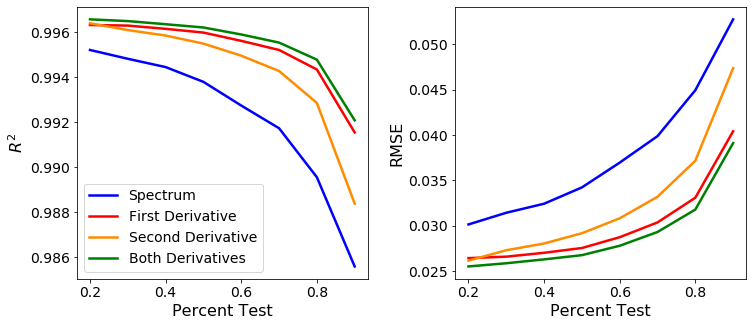

In [32]:
plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,5])
plt.subplots_adjust(wspace=0.3)
ax1.plot(size_list, spectrum_R2, c='blue', lw=2.5, label='Spectrum')
ax1.plot(size_list, dmu1_R2, c='red', lw=2.5, label='First Derivative')
ax1.plot(size_list, dmu2_R2, c='darkorange', lw=2.5, label='Second Derivative')
ax1.plot(size_list, dmu_both_R2, c='green', lw=2.5, label='Both Derivatives')
ax1.set_xlabel('Percent Test', fontsize=16)
ax1.set_ylabel('$R^2$', fontsize=16)
ax2.plot(size_list, spectrum_RMSE, c='blue', lw=2.5)
ax2.plot(size_list, dmu1_RMSE, c='red', lw=2.5)
ax2.plot(size_list, dmu2_RMSE, c='darkorange', lw=2.5)
ax2.plot(size_list, dmu_both_RMSE, c='green', lw=2.5)
ax2.set_xlabel('Percent Test', fontsize=16)
ax2.set_ylabel('RMSE', fontsize=16)
ax1.legend()
plt.show()